In [5]:
import torch
from torch import nn, optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

In [7]:
# Load the pretrained ResNet18 model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Modify the final layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # Output layer with a single unit for binary classification

# Define the device and move model to it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define a loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # For binary classification with sigmoid
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [8]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Load data
train_data = ImageFolder("/raid/home/minan/home/project/project/newdataset/train", transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

test_data = ImageFolder("/raid/home/minan/home/project/project/newdataset/test", transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [9]:
# Define accuracy function
def calculate_accuracy(loader, model):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            predictions = (torch.sigmoid(outputs) > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [10]:
# Training loop with accuracy tracking
num_epochs = 30
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate accuracy
    train_accuracy = calculate_accuracy(train_loader, model)
    test_accuracy = calculate_accuracy(test_loader, model)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch [1/30], Loss: 0.3869, Train Accuracy: 0.7334, Test Accuracy: 0.6709
Epoch [2/30], Loss: 0.2714, Train Accuracy: 0.6447, Test Accuracy: 0.6456
Epoch [3/30], Loss: 0.5181, Train Accuracy: 0.7497, Test Accuracy: 0.6835
Epoch [4/30], Loss: 0.3739, Train Accuracy: 0.8512, Test Accuracy: 0.7215
Epoch [5/30], Loss: 0.1163, Train Accuracy: 0.9010, Test Accuracy: 0.6962
Epoch [6/30], Loss: 0.3817, Train Accuracy: 0.8422, Test Accuracy: 0.6582
Epoch [7/30], Loss: 0.0628, Train Accuracy: 0.9440, Test Accuracy: 0.7215
Epoch [8/30], Loss: 0.1445, Train Accuracy: 0.9807, Test Accuracy: 0.7595
Epoch [9/30], Loss: 0.0287, Train Accuracy: 0.9825, Test Accuracy: 0.7468
Epoch [10/30], Loss: 0.1230, Train Accuracy: 0.9737, Test Accuracy: 0.7215
Epoch [11/30], Loss: 0.0399, Train Accuracy: 0.9837, Test Accuracy: 0.7595
Epoch [12/30], Loss: 0.2659, Train Accuracy: 0.9492, Test Accuracy: 0.7342
Epoch [13/30], Loss: 0.0042, Train Accuracy: 0.9915, Test Accuracy: 0.7468
Epoch [14/30], Loss: 0.0486, Train

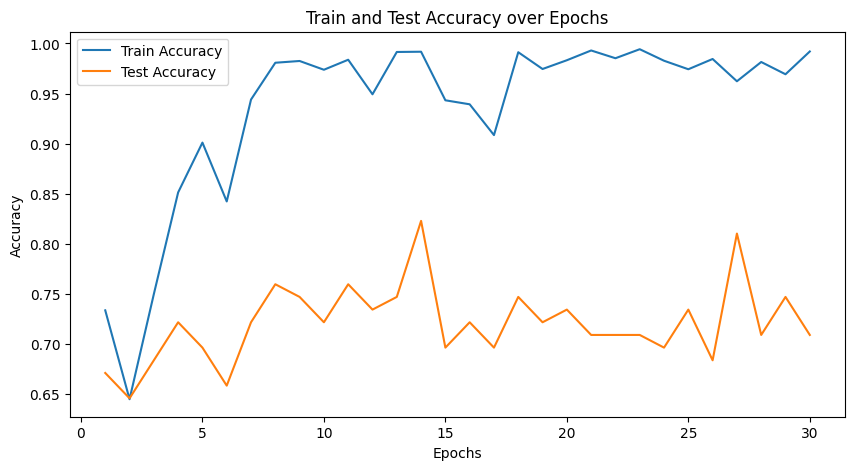

In [11]:
# Plotting the training and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over Epochs')
plt.legend()
plt.show()